In [1]:
#Import libraries

import numpy as np 
import torch
from scipy.integrate import simps


In [2]:
#Import helper functions 

from FourierGridMethod import Fourier_Grid
from Generate_fields import random_perturbation
from potfields import potential,electric_field,alpha
from new_split import split_op
from plot_utils import animate_dyn,plot_eig,plot_perturbation,plot_wavepacket

In [3]:
#Setting variables for the simulation
#the hamiltonian for the system is 

# Define the x and y coordinates of the grid

x_min, x_max = -90*np.pi/180, 90*np.pi/180
y_min, y_max = 0, 7.25
x_size, y_size = 200, 300

#Define x and y grids
x_grid = np.linspace(x_min, x_max, x_size)
y_grid = np.linspace(y_min, y_max, y_size)

#Define meshgrid terms for 3D plots and making perturbations
x_dim, t_dim = np.meshgrid(x_grid, y_grid)

In [4]:
#Scale for unit conversion to au
ev_scale=1/(27*1e3)

In [5]:
#Values for inertia 
IBr=8911925
IF=1864705

#Calculate Irel
Irel=(IBr*IF)/(IBr+IF)

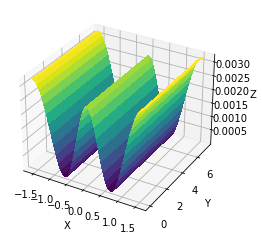

In [6]:
#Generate the double well potential
V_pot=potential(x_grid,y_grid)

#scale and plot
V_mev=ev_scale*(V_pot)

%matplotlib inline
V_plot=plot_perturbation(x_grid,y_grid,V_mev)

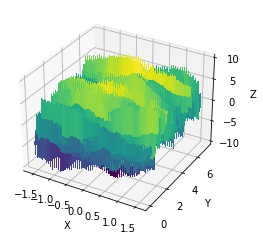

In [7]:
#coherence and variance in amplitude for term1
phi_coh_x = 12.2
phi_coh_y = 0.27
phi_amp_var=11.9

#Generate the n_v term and plot it. This term is in mev
phi_perturb=random_perturbation(x_size,y_size,phi_coh_x,phi_coh_y,phi_amp_var)

%matplotlib inline
phi_noise_plot=plot_perturbation(x_grid,y_grid,phi_perturb)


In [17]:
#Add the two terms and compute fourier grid hamiltonian at steps t=0 and t=T
#These serve as the initial wavepacket for the laser system, and the final wavepacket for the comparision

V_vib=ev_scale*(V_pot+phi_perturb)

#FGH at step 0
E0,psi0=Fourier_Grid(Irel,x_size,x_max-x_min,V_vib[0])

#Normalise the initial wavepacket

for i in range(0,5):
   WF_norm = simps(np.abs(psi0[:,i])**2, x=x_grid)
   psi0[:,i] /= np.sqrt(WF_norm)

#FGH at step t
Et,psit=Fourier_Grid(Irel,x_size,x_max-x_min,V_vib[y_size-1])



#Normalise the final states

for i in range(0,5):
   WF_norm = simps(np.abs(psit[:,i])**2, x=x_grid)
   psit[:,i] /= np.sqrt(WF_norm)


In [18]:
def normalize_wfn(psi,x_grid,n):
    for i in range(0,n):
       WF_norm = simps(np.abs(psi[:,i])**2, x=x_grid)
       psi[:,i] /= np.sqrt(WF_norm)
        
    return psi



In [40]:
#identify which side of the well the wavepacket is.
def side_wp(psi,well_side):
    
    side=np.zeros(len(psi[0,:]))
    for i in range(len(psi)):
        ind = np.argmax(psi[:,i])
        if ind < 100 :
            well=-1
        else : 
            well=1
        side[i]=well
        
    #indices of all wells on the left side (with -1 in side)
    indices=[i for i, x in enumerate(side) if x == well_side]
    
    #take the lowest index
    val_tk=indices[0]
    print(val_tk)
    return val_tk



0
0.9999999999999997
E[0] = -0.00013023392287833327
1.0
E[1] = -9.782928961884978e-06
1.0000000000000002
E[2] = -8.300293970027112e-06
1.0
E[3] = 0.00011214878754932936
1.0
E[4] = 0.00011574955274983595


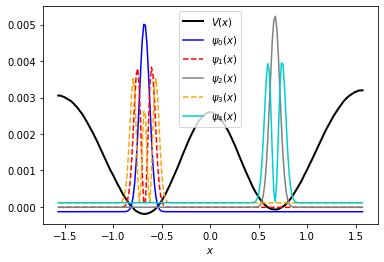

In [41]:
pside=side_wp(psi0,-1)
#Plot initial wavepackets
%matplotlib inline
plot_eig(x_grid,V_vib[0],E0,psi0)


1
1.0
E[0] = -5.93089677941281e-05
1.0000000000000002
E[1] = -4.9535826146325645e-05
0.9999999999999999
E[2] = 6.839627731594113e-05
1.0
E[3] = 7.329904732542719e-05
1.0000000000000004
E[4] = 0.00019342718752647848


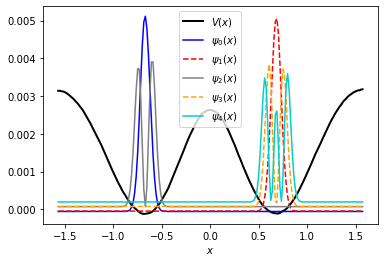

In [42]:
pside=side_wp(psit,1)
#Plot final reference wavepackets
%matplotlib inline
plot_eig(x_grid,V_vib[y_size-1],Et,psit)

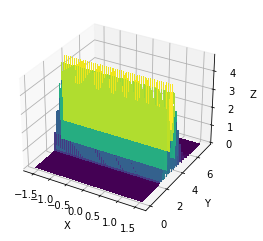

In [12]:
#Generate the electric field causing the distortion. This is in ev unless scaled
sig=0.8
t0=2.0
t1=3
k=8
k1=10

# Evaluate the electric field at the points in the meshgrid
elec_f = electric_field(k,k1,t0,t1,sig, x_dim, t_dim)
%matplotlib inline
plot_laser=plot_perturbation(x_grid,y_grid,elec_f)

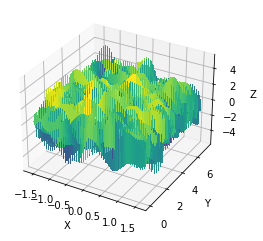

In [13]:
#coherence and variance in amplitude for term2 this is in ev unless scaled
eta_coh_x = 12.2
eta_coh_y = 0.27
A1=np.amax(elec_f)
eta_amp_var=11.9*4/(A1)**2

#Generate the n_alpha term and plot it 
eta_perturb=random_perturbation(x_size,y_size,eta_coh_x,eta_coh_y,eta_amp_var)

%matplotlib inline
eta_noise_fig=plot_perturbation(x_grid,y_grid,eta_perturb)

#Generate the alpha term
alpha_1=np.vectorize(alpha)(x_grid)

In [14]:
#Add the terms to form the total potential and scale it
V_tot=V_pot+phi_perturb-0.25*(elec_f**2)*(alpha_1+eta_perturb)
V_tot_au=ev_scale*(V_tot)


In [15]:
#Propagate the wavepacket using the splitoperator method

#Initialise the split operator class
timestep=990
rabi=split_op(xmin=x_min,xmax=x_max,Nx=x_size,nt=y_size,dt=timestep,t_end=timestep*y_size, device=None,dtype=torch.float64)

#Set the wavepacket to an intital wavepacket
u=torch.tensor(psi0[:,0],dtype=torch.complex64)

#Propagate the wavepacket
U,D,ux=rabi.split_op(u,torch.tensor(V_tot_au))
   

<IPython.core.display.Javascript object>


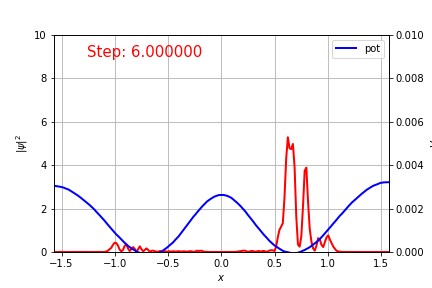

In [16]:
%matplotlib notebook
t=animate_dyn(x_min,x_max,0,100,x_grid,D,V_tot_au)

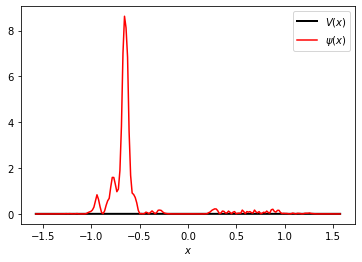

In [17]:
#View the final wavepacket

%matplotlib inline
plot_wavepacket(x_grid,V_tot_au[y_size-1],U[y_size-1])

In [18]:
#define the overlap of the wavepackets
psi_sim=U[y_size-1].numpy()
overlap= abs(x_grid[0]-x_grid[1])*np.sum(np.conj(psi_sim) * psit)
fitness=np.abs(overlap**2)
print(fitness)

0.014726384552987165


In [19]:

def complete_simulation(x_grid,t_grid,V_vib,phi_perturb,eta_perturb,alpha,params=None):
    if params is None:
        params = {'sig':0.8,'t0':2.0,'t1':3,'k':8,'k1':10}
    sig = params.get('sig', 1.0)
    t0 = params.get('t0', 2.0)
    t1 = params.get('t1', 3.0)
    k = params.get('k', 4.0)
    k1 = params.get('k1', 5.0)
    
    x_max=np.max(x_grid)
    x_min=np.min(x_grid)
    nstates=5
    
    x_dim, t_dim = np.meshgrid(x_grid, y_grid)
    
    elec_f = electric_field(k,k1,t0,t1,sig, x_dim, t_dim)
    
    #FGH at step 0 and normalisation
    E0,psi0=Fourier_Grid(Irel,x_size,x_max-x_min,V_vib[0])
    psi0=normalize_wfn(psi0,x_grid,nstates)

    #FGH at step t and normalisation
    Et,psit=Fourier_Grid(Irel,x_size,x_max-x_min,V_vib[y_size-1])
    psit=normalize_wfn(psi0,x_grid,nstates)

    #Propagate the wavepacket
    V_tot=V_pot+phi_perturb-0.25*(elec_f**2)*(alpha_1+eta_perturb)
    V_tot_au=ev_scale*(V_tot)
    
    timestep=990
    rabi=split_op(xmin=x_min,xmax=x_max,Nx=x_size,nt=y_size,dt=timestep,t_end=timestep*y_size, device=None,dtype=torch.float64)

    #Set the wavepacket to an intital wavepacket
    u=torch.tensor(psi0[:,0],dtype=torch.complex64)

    #Split_operator
    U,D,ux=rabi.split_op(u,torch.tensor(V_tot_au))
    
    psi_sim=U[y_size-1].numpy()
    overlap= abs(x_grid[0]-x_grid[1])*np.sum(np.conj(psi_sim) * psit)
    fitness=np.abs(overlap**2)
    
    return fitness
   
    


In [20]:

elec_params={'sig':0.8,'t0':2.0,'t1':3,'k':8,'k1':100}
f_sim=complete_simulation(x_grid,y_grid,V_vib,phi_perturb,eta_perturb,alpha_1,params=elec_params)

In [21]:
print(f_sim)

0.039815384803988954
